# MRI Brain Tumor Segmentation

In this project, we will segment a brain tumor in MRI Images.

We will use `ResUNet Architecture` for the segmentation.

Also We will use `PyTorch`.

Dataset: [Brain MRI Segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation) 

We will follow this order:
1. Get data
2. Create datasets and dataloaders
3. Create Model
4. Train Model
5. Save Model
6. Evaluate and Visualize the model

## 1. Get Data

Download the data with following command from the command line.
```
!kaggle datasets download -d dmateuszbuda/lgg-mri-segmentation
```

**Note**: You may need to install and configure `kaggle` before downloading the data.

It will download the data with filename `lgg-mri-segmentation.zip`

We have to extract the data and set it up to create our datasets and dataloaders.

In [3]:
from pathlib import Path
from zipfile import ZipFile

data_path = Path('data')
mri_data_path = data_path/'mri_brain_tumor'

if mri_data_path.is_dir():
    print(f'{mri_data_path} already exists!')
else:
    mri_data_path.mkdir(parents=True, exist_ok=True)
    print(f'{mri_data_path} folders created')

zip_file_name = 'lgg-mri-segmentation.zip'

with ZipFile(zip_file_name, 'r') as zipfile:
    print('extracting...')
    zipfile.extractall(mri_data_path)
    print('extracted.')

data/mri_brain_tumor already exists!
extracting...
extracted.


In [4]:
import pandas as pd
import numpy as np

import torch
import torchvision

In [5]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
# check datasets
brain_df = pd.read_csv('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/data.csv')
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

From the data we can see that we have total of `110` patients. 

That means there are images of `110` patients in the data.

In [7]:
import os
import random

all_imgs = list(mri_data_path.glob('*/*/*/*'))

# lets select random 5 images to see how the paths look like
random.seed(42) # seeding for reproducibility
random_samples = random.sample(all_imgs, k=5)

random_samples

[PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_7_mask.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_39.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_19_mask.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_20.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_13.tif')]

We can see that some images are ending with `mask.tif` and some are not ending with that.

That means we have images and their respective mask in the data.

Let's visualize and see.

Lets take the `2nd data` from the random sample:

`PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_39.tif')`


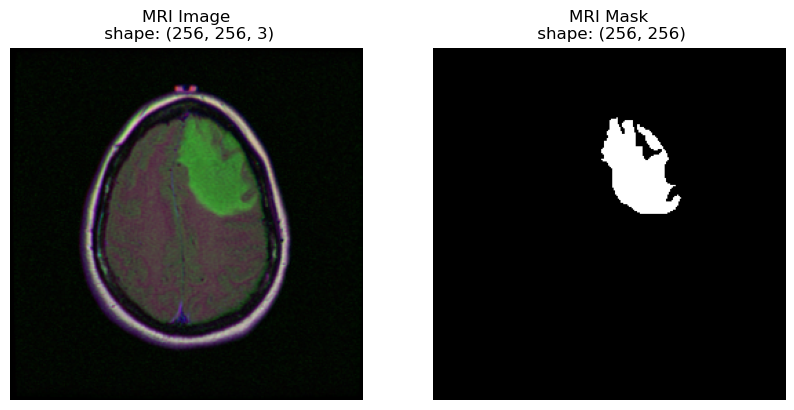

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

# load the image
random_img = random_samples[1]
img = Image.open(random_img)

# get img folder
img_folder_path = random_img.parent

# getting just the name of the image
img_name = random_img.stem

# adding _mask in the image name to get the mask of the image
mask_name = f"{img_name.split('.tif')[0]}_mask.tif"

# adding together the img folder and the name of the mask to get the full path
# of the mask
mask_img_path = img_folder_path/mask_name

# loading the mask image
mask_img = Image.open(mask_img_path)

# turn the images(img and mask) into array before visualizing
img_asarray = np.asarray(img)
mask_img_asarray = np.asarray(mask_img)

# let's visualize the img and its mask

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(img_asarray)
plt.title(f'MRI Image\n shape: {img_asarray.shape}')
plt.axis(False)

plt.subplot(1,2,2)
plt.imshow(mask_img_asarray, cmap='gray') # we should do color map (cmap=gray) because by default matplotlib doesn't show grayscale images
plt.title(f'MRI Mask\n shape: {mask_img_asarray.shape}') # to see the shape of the image
plt.axis(False);


Beaufiful!

Now we have a image and its mask, and we know how the path to those image and mask look like.
Image: 'data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/`TCGA_DU_6401_19831001_39.tif`'

Mask: 'data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/`TCGA_DU_6401_19831001_39_mask.tif`'

### 1.1 Lets understand our data more.

We have to first divide our data to images and its masks.

We can do that by creating a function where we send the path to the images folder and it will return image paths and mask paths.

In [9]:
from typing import Tuple, List
import fnmatch 

def get_imgs_and_masks(mri_data_path:str) :# -> Tuple[List, List]:
    all_images = list(mri_data_path.glob("*/*.tif")) # both img and masks
    pattern_for_mask = '*_mask.tif'

    imgs = []
    masks =  []
    
    # images are all paths that doesn't match the patten
    for img_path in all_images:
        # loop through only if the mask patten is not matched
        if not fnmatch.fnmatch(img_path, pattern_for_mask):
            imgs.append(img_path)
    
            # get img folder
            img_folder_path = img_path.parent
            
            # getting just the name of the image
            img_name = img_path.stem
            
            # adding _mask in the image name to get the mask of the image
            mask_name = f"{img_name.split('.tif')[0]}_mask.tif"
            
            # adding together the img folder and the name of the mask to get the full path
            # of the mask
            mask_img_path = img_folder_path/mask_name
    
            # append the mask img path to the masks list
            masks.append(mask_img_path)

    return imgs, masks
    
mri_data_path = Path('data/mri_brain_tumor/kaggle_3m')
imgs, masks = get_imgs_and_masks(mri_data_path)
imgs[1], masks[1]
# print(imgs)

(PosixPath('data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8.tif'),
 PosixPath('data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8_mask.tif'))

Let's see how many imgs and masks we have:

In [10]:
len(imgs), len(masks)

(3929, 3929)

Great!

We have `3929` imgs and masks pairs.

Lets visualize couple of pairs.

Because I like visualizing!!!

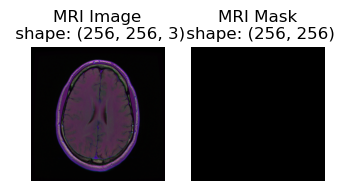

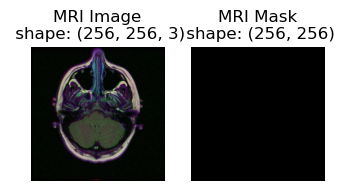

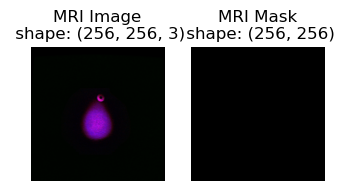

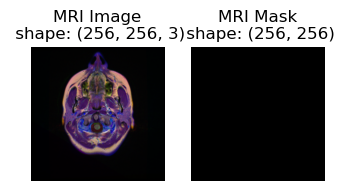

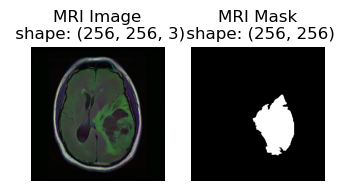

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

# Lets get random 5 samples from the imgs
# comment random seed to see different images
random.seed(42) # to make it reproducible
random_indexes = random.sample(range(len(imgs)), k=5)
random_indexes

for idx in range(len(random_indexes)):
    img = imgs[random_indexes[idx]]
    mask = masks[random_indexes[idx]]

    img = Image.open(img)
    mask = Image.open(mask)

    # turn the images(img and mask) into array before visualizing
    img_asarray = np.asarray(img)
    mask_img_asarray = np.asarray(mask)
    
    # let's visualize the img and its mask
    
    plt.figure(figsize=(10,8))
    
    plt.subplot(2,5,1)
    plt.imshow(img_asarray)
    plt.title(f'MRI Image\n shape: {img_asarray.shape}')
    plt.axis(False)
    
    plt.subplot(2,5,2)
    plt.imshow(mask_img_asarray, cmap='gray') # we should do color map (cmap=gray) because by default matplotlib doesn't show grayscale images
    plt.title(f'MRI Mask\n shape: {mask_img_asarray.shape}') # to see the shape of the image
    plt.axis(False);
    

Amazing!!!

We just visualized the data we have - Image and its corresponding masks.

We can see that some of them do not have masks in them.

This is because, the images that have corresponing masks, are the MRI images with Brain tumor.

And the images that do not have corresponding masks, are the MRI image without Brain tumor.

In our above visualization, `top 4 are the one with no Brain Tumor` and the `one at the botton has Brain Tumor`.

**Now Lets create a DataFrame that contains `image ID`, `Image path`, `Mask path`, and `whether it has tumor`**


In [12]:
from PIL import Image
# loop through all the imgs
img_ids = []
has_tumor = []
for idx in range(len(imgs)):
    ids = imgs[idx].stem.split('.tif')[0]
    img_ids.append(ids)

    # check pixel in mask, if the pixel is more than 0, then it has tumor
    # because masks with no tumor is a blank image - image with 0 pixel values
    mask = Image.open(masks[idx])
    mask_asarray = np.asarray(mask)
    is_tumor = np.where(np.max(mask_asarray)>0, 1, 0)
    has_tumor.append(is_tumor)
has_tumor[:3]
    

[array(0), array(0), array(1)]

In [13]:
data_dataframe = pd.DataFrame({
    'ids': img_ids,
    'img_paths': imgs,
    'mask_paths': masks,
    'is_tumor': has_tumor
}).reset_index(drop=True)

data_dataframe.head()

,ids,img_paths,mask_paths,is_tumor
0,TCGA_CS_6667_20011105_9,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,0
1,TCGA_CS_6667_20011105_8,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,0
2,TCGA_CS_6667_20011105_16,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,1
3,TCGA_CS_6667_20011105_17,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,1
4,TCGA_CS_6667_20011105_15,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,data/mri_brain_tumor/kaggle_3m/TCGA_CS_6667_20...,1


Beautiful!!! 
We got our dataframe.

Now we will use this dataframe to create our dataset and dataloaders.

Lets do it.

## 2. Create datasets and dataloaders

Lets setup our cutom datasets for our segmentation task.

### 2.1 Datasets

In [14]:
from torch.utils.data import Dataset
from PIL import Image
from typing import Tuple

class CustomSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms):
        self.image_paths =  image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self) -> int:
        """
        Returns the length of the dataset
        """
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            image and mask at given idx
        """
        # get image and mask path for the idx
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # load the image and mask
        img = Image.open(image_path)
        mask = Image.open(mask_path)

        # apply the transform if transform exists
        if self.transforms:
            img = self.transforms(img)
            mask = self.transforms(mask)

        return img, mask

Sweet!

Now that we have our `CustomSegmentationDataset` function.

Lets split our image directories into train and test directories.

We'll use `80:20` split.

In [15]:
data_dataframe.columns

Index(['ids', 'img_paths', 'mask_paths', 'is_tumor'], dtype='object')

In [16]:
from sklearn.model_selection import train_test_split

train_img_dir, test_img_dir, train_mask_dir, test_mask_dir = train_test_split(data_dataframe['img_paths'].tolist(), # we should do to list here to make sure wereset the index
                                                                                    data_dataframe['mask_paths'].tolist(),
                                                                                    test_size=0.2, 
                                                                                    random_state=42)
print(f'Train image, mask size: {len(train_img_dir), len(train_mask_dir)}')
print(f'Test image, mask size: {len(test_img_dir), len(test_mask_dir)}')                                              

Train image, mask size: (3143, 3143)
Test image, mask size: (786, 786)


/Users/socms/miniforge3/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Now that we have, train and test directories, lets create a transform to load the dataset.

In [17]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=-.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

Great.

Now that we have a train and test transforms, we can pass them to load our dataset.

In [18]:
train_dataset = CustomSegmentationDataset(train_img_dir, train_mask_dir, transforms=train_transforms)
test_dataset = CustomSegmentationDataset(test_img_dir, test_mask_dir, transforms=test_transforms)

len(train_dataset), len(test_dataset)

(3143, 786)

Our dataset will return an image and its corresponding mask.

In [19]:
img, mask = next(iter(train_dataset))
img, mask

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

Now lets display random images from our custom dataset.

we will get 10 random images and display them.

we will:
1. Get random 10 indexes from the dataset.
2. Setup matplotlib.
3. Loop through the random images and plot them in matplotlib.
4. Make sure the dimension of our images line up with matplotlib
5. Plot the adjusted image and masks

In [20]:
train_dataset

In [21]:
import random

def plot_random_images(dataset: torch.utils.data.Dataset,
                       n: int = 10,
                       seed: int = None):

    if seed:
        random.seed(42)
    
    # 1. Get random 10 indexes from the dataset
    random_sample_idxs = random.sample(range(len(dataset)), k = n)
    random_sample_idxs
    
    # 2. setup matplotlib
    plt.figure(figsize=(16,8))
    
    # 3. Loop through the random images and plot them in matplotlib
    for i, idx in enumerate(random_sample_idxs):
        img, mask = dataset[idx]
    
        # 4. adjusting images tensor dimensions for matplotlib
        img_adjusted = img.permute(1,2,0)
        mask_adjusted = mask.permute(1,2,0)
    
        # 5. plot the adjusted image and masks
        plt.subplot(1, n, i+1)
        plt.imshow(img_adjusted)
        plt.title(f'img')
        
        plt.subplot(2, n, i+1)
        plt.imshow(mask_adjusted)
        plt.title(f'mask')

Great!

Now we have a function to plot random images

lets plot random train and test data.

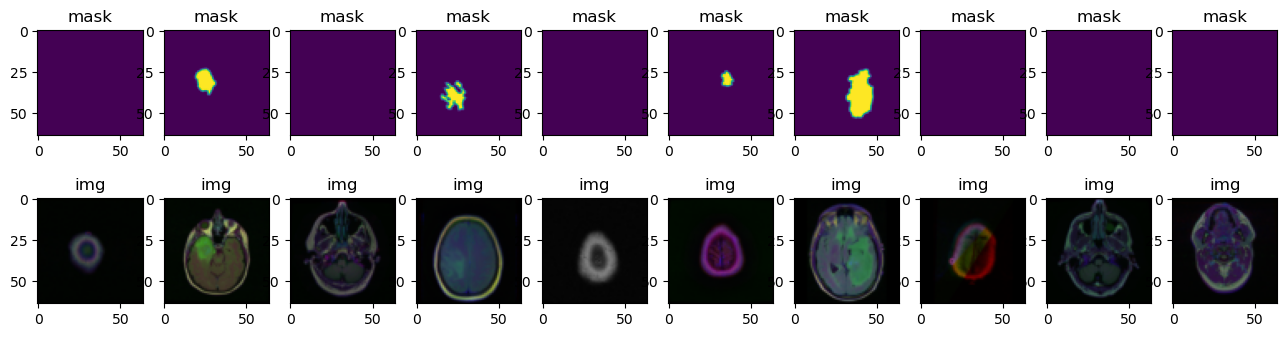

In [22]:
# plot random 10 train dataset
plot_random_images(dataset=train_dataset, n=10, seed=42)

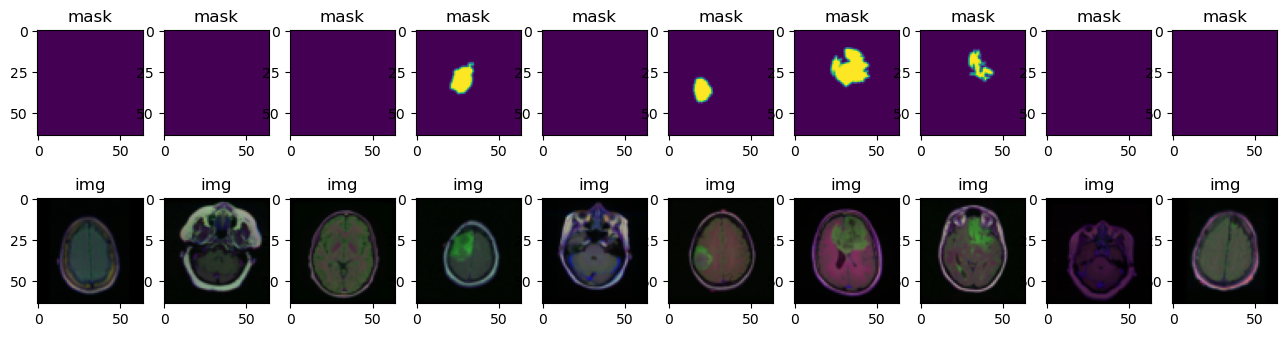

In [23]:
# plot random 10 test dataset
plot_random_images(dataset=test_dataset, n=10, seed=42)

Great!

Now our dataset is ready.
Lets create a `DataLoader` now

### 2.2 DataLoader

Lets turn our dataset into a dataloader now.

In [24]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = 0 # set 0 to disable multiprocessing 

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers = NUM_WORKERS)

In [25]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x134241db0>,
 <torch.utils.data.dataloader.DataLoader at 0x134241bd0>)

In [26]:
img, mask = next(iter(train_dataloader))
img.shape, mask.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32, 1, 64, 64]))

## 3. Create a Model

Now that we have our datasets and dataloaders, we can start building our model.

We are doing segmentation here.

There are multiple algorithms available that can help us to segmentation.

We will first start with `UNet Algorithm`. 
- First we will create the algorithm by ourself and
- then we will use Transfer learning and utilize Torchvision Models.

### 3.1 Model 0: UNet

[Unet](https://paperswithcode.com/paper/u-net-convolutional-networks-for-biomedical) is a convolutional neural network architecture for biological image segmentation. Specifically for semantic segmentation. The architecture looks like `U`, hence the name.
![](UnetArchitecture.png)

It consists of the repeated application of `two 3x3 convolutions (unpadded convolutions)`, each `followed by a rectified linear unit (ReLU)` and `a 2x2 max pooling operation with stride 2` for downsampling.